In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.autograd import Function
from matplotlib import pyplot as plt
from itertools import product
from Models_and_losses import *

In [0]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [0]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [0]:
EPS = 1e-4
Sigma = {1:4,2:3,3:2.25,4:2,5:2,6:1.9,7:1.75,8:1.75,9:1.7,10:1.65}
p = 0.05

In [0]:
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [0]:
X, y = load_boston(return_X_y=True)

X = StandardScaler().fit_transform(X)

y = StandardScaler().fit_transform(np.expand_dims(y, -1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

X_train, y_train = torch.tensor(X_train).float(), torch.tensor(y_train).float()

X_test, y_test = torch.tensor(X_test).float(), torch.tensor(y_test).float()

ds_train = torch.utils.data.TensorDataset(X_train, y_train)

dataloader_train = torch.utils.data.DataLoader(ds_train, batch_size=16, shuffle=True)

ds_test = torch.utils.data.TensorDataset(X_test, y_test)

dataloader_test = torch.utils.data.DataLoader(ds_test, batch_size=16, shuffle=True)

In [0]:
n_layers = 2
TRAIN_LENGTH = int(X_train.shape[0])
regressor = Bayesian_ReLU(13, 2, n_layers).to(device)
optimizer = optim.Adam(regressor.parameters(), lr=1e-2)

In [8]:
%%time
ls = []
n_iter = 0
flag = 0
for epoch in range(100):
  for i, (datapoints, labels) in enumerate(dataloader_train):
    optimizer.zero_grad()

    loss = elbo_loss(regressor,datapoints,labels,n_layers,TRAIN_LENGTH,n_samples = 32)

    loss.backward()

    ls.append(loss.item())

    optimizer.step()



CPU times: user 1min 46s, sys: 188 ms, total: 1min 46s
Wall time: 1min 47s


In [9]:
regressor.eval()

Bayesian_ReLU(
  (linear_in): Random_Linear()
  (hid_layers): Sequential(
    (0): Random_Linear()
    (1): ReLU()
  )
  (linear_out): Random_Linear()
)

In [0]:
res = regressor(X_test)

In [0]:
mu = res[:,0].detach().numpy()

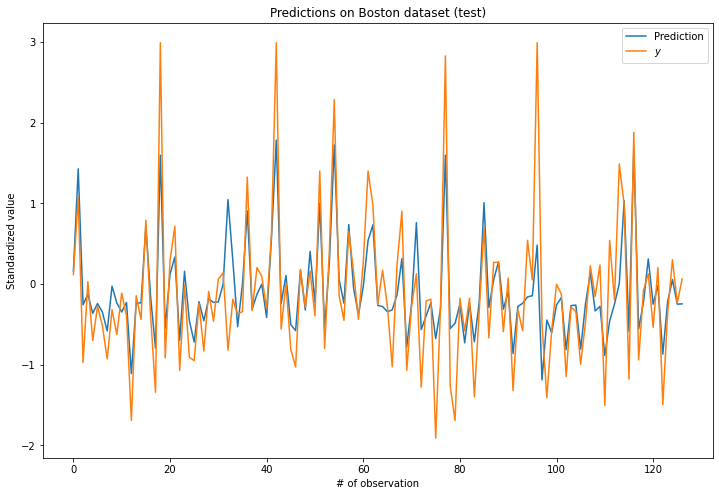

In [12]:
plt.figure(figsize=(12,8))
plt.plot(mu,label='Prediction')
plt.plot(y_test,label='$y$')
plt.legend()
plt.title('Predictions on Boston dataset (test)')
plt.xlabel('# of observation')
plt.ylabel('Standardized value')
plt.grid(True)
plt.show()

In [0]:
def model_2d(data):
  x = data[:,0]
  y = data[:,1]
  real_labels = torch.sin(12*x*y) + 0.66*torch.cos(25*(x+y)) + torch.exp(x-y)
  return real_labels


In [0]:
x1 = np.random.normal(-1/2**0.5*np.ones(100),np.ones(100)/10)
y1 = np.random.normal(-1/2**0.5*np.ones(100),np.ones(100)/10)

x2 = np.random.normal(1/2**0.5*np.ones(100),np.ones(100)/10)
y2 = np.random.normal(1/2**0.5*np.ones(100),np.ones(100)/10)

# x3 = np.random.normal(1/2**0.5*np.ones(100),np.ones(100)/10)
# y3 = np.random.normal(-1/2**0.5*np.ones(100),np.ones(100)/10)

# x4 = np.random.normal(-1/2**0.5*np.ones(100),np.ones(100)/10)
# y4 = np.random.normal(1/2**0.5*np.ones(100),np.ones(100)/10)

In [0]:
x = np.concatenate([x1,x2
                    # ,x3,x4
                    ])
y = np.concatenate([y1,y2
                    # ,y3,y4
                    ])

In [0]:
tau = 1
points = torch.Tensor(np.stack([x,y],axis=1))
target = (model_2d(points)+torch.normal(torch.zeros_like(points[:,0]),torch.ones_like(points[:,0])/np.sqrt(tau) ))[:,None]

In [0]:
grid_x = np.linspace(-2,2,200)
grid_y = np.linspace(-2,2,200)
grid = torch.Tensor(list(product(grid_x,grid_y)))
xx, yy = np.meshgrid(grid_x,grid_y)

In [0]:
TRAIN_LENGTH = target.shape[0]

In [19]:
n_layers = 1
regressor = Bayesian_ReLU(2, 2, n_layers).to(device)
optimizer = optim.Adam(regressor.parameters(), lr=1e-2)
regressor.train()

Bayesian_ReLU(
  (linear_in): Random_Linear()
  (linear_out): Random_Linear()
)

In [0]:
ls = []
for epoch in range(1000):
  optimizer.zero_grad()

  loss = elbo_loss(regressor,points,target,n_layers,TRAIN_LENGTH,n_samples = 32)

  loss.backward()

  ls.append(loss.item())

  optimizer.step()

In [21]:
regressor.eval()

Bayesian_ReLU(
  (linear_in): Random_Linear()
  (linear_out): Random_Linear()
)

In [0]:
T = torch.stack([torch.log(1+EPS+torch.exp(regressor(grid)[:,1])) for i in range(50)],dim=0)
std = T.mean(dim=0)
zz = std.reshape(200,200).detach().numpy()

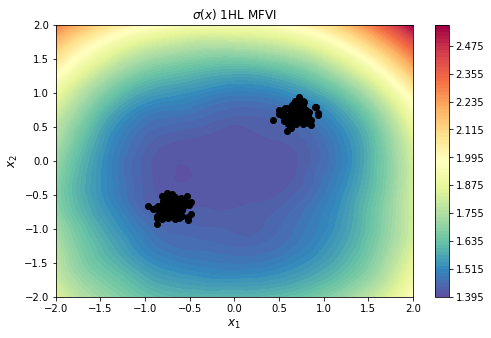

In [23]:
plt.figure(figsize=(8,5))
plt.contourf(xx, yy, zz, 100, cmap='Spectral_r')
plt.colorbar()
plt.scatter(x,y,color='black')
plt.title('$\sigma(x)$ 1HL MFVI',fontsize=12)
plt.xlabel('$x_1$',fontsize=12)
plt.ylabel('$x_2$',fontsize=12)
plt.show()

In [24]:
n_layers = 1
MCDO_reg = MCDO(2, 1, n_layers).to(device)
optimizer = optim.Adam(MCDO_reg.parameters(), lr=1e-3)
MCDO_reg.train()

MCDO(
  (linear_in): Linear(in_features=2, out_features=50, bias=True)
  (dropout_in): Dropout(p=0.05, inplace=False)
  (linear_out): Linear(in_features=50, out_features=1, bias=True)
)

In [0]:
ls = []
for epoch in range(1000):
  optimizer.zero_grad()

  loss = MCDO_loss(MCDO_reg,points,target,n_layers)

  loss.backward()

  ls.append(loss.item())

  optimizer.step()

In [0]:
T = torch.stack([MCDO_reg(grid) for i in range(200)],dim=0)

In [0]:
zz = T.std(dim=0).reshape(200,200).detach().numpy()

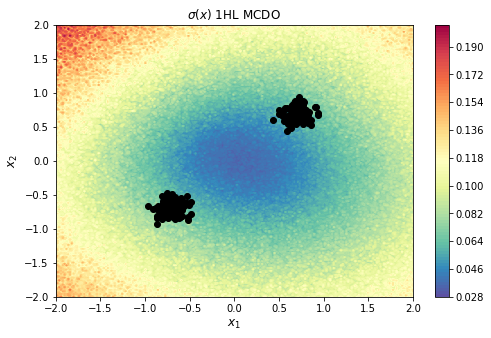

In [28]:
plt.figure(figsize=(8,5))
plt.contourf(xx, yy, zz, 100, cmap='Spectral_r')
plt.colorbar()
plt.scatter(x,y,color='black')
plt.title('$\sigma(x)$ 1HL MCDO',fontsize=12)
plt.xlabel('$x_1$',fontsize=12)
plt.ylabel('$x_2$',fontsize=12)
plt.show()

In [29]:
n_layers = 2
regressor = Bayesian_ReLU(2, 2, n_layers).to(device)
optimizer = optim.Adam(regressor.parameters(), lr=1e-2)
regressor.train()

Bayesian_ReLU(
  (linear_in): Random_Linear()
  (hid_layers): Sequential(
    (0): Random_Linear()
    (1): ReLU()
  )
  (linear_out): Random_Linear()
)

In [0]:
ls = []
for epoch in range(1000):
  optimizer.zero_grad()

  loss = elbo_loss(regressor,points,target,n_layers,TRAIN_LENGTH,n_samples = 32)

  loss.backward()

  ls.append(loss.item())

  optimizer.step()

In [31]:
regressor.eval()

Bayesian_ReLU(
  (linear_in): Random_Linear()
  (hid_layers): Sequential(
    (0): Random_Linear()
    (1): ReLU()
  )
  (linear_out): Random_Linear()
)

In [0]:
T = torch.stack([torch.log(1+EPS+torch.exp(regressor(grid)[:,1])) for i in range(50)],dim=0)
std = T.mean(dim=0)
zz = std.reshape(200,200).detach().numpy()

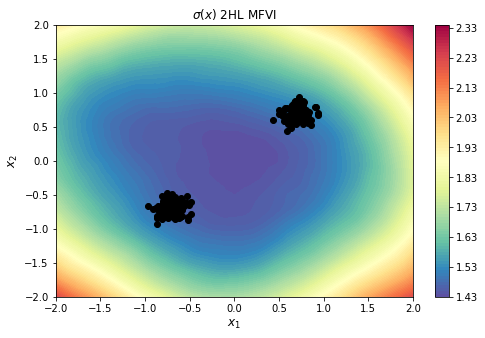

In [33]:
plt.figure(figsize=(8,5))
plt.contourf(xx, yy, zz, 100, cmap='Spectral_r')
plt.colorbar()
plt.scatter(x,y,color='black')
plt.title('$\sigma(x)$ 2HL MFVI',fontsize=12)
plt.xlabel('$x_1$',fontsize=12)
plt.ylabel('$x_2$',fontsize=12)
plt.show()

In [34]:
n_layers = 2
MCDO_reg = MCDO(2, 1, n_layers).to(device)
optimizer = optim.Adam(MCDO_reg.parameters(), lr=1e-3)
MCDO_reg.train()

MCDO(
  (linear_in): Linear(in_features=2, out_features=50, bias=True)
  (dropout_in): Dropout(p=0.05, inplace=False)
  (hid_layers): Sequential(
    (0): Linear(in_features=50, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.05, inplace=False)
  )
  (linear_out): Linear(in_features=50, out_features=1, bias=True)
)

In [0]:
ls = []
for epoch in range(1000):
  optimizer.zero_grad()

  loss = MCDO_loss(MCDO_reg,points,target,n_layers)

  loss.backward()

  ls.append(loss.item())

  optimizer.step()

In [0]:
T = torch.stack([MCDO_reg(grid) for i in range(200)],dim=0)

In [0]:
zz = T.std(dim=0).reshape(200,200).detach().numpy()

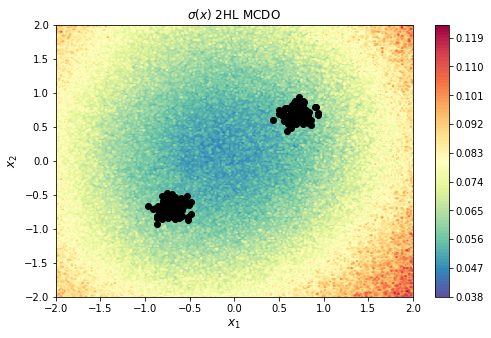

In [38]:
plt.figure(figsize=(8,5))
plt.contourf(xx, yy, zz, 100, cmap='Spectral_r')
plt.colorbar()
plt.scatter(x,y,color='black')
plt.title('$\sigma(x)$ 2HL MCDO',fontsize=12)
plt.xlabel('$x_1$',fontsize=12)
plt.ylabel('$x_2$',fontsize=12)
plt.show()

In [0]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF, ConstantKernel as C

In [0]:
target_np = target.detach().numpy()
points_np = points.detach().numpy()

In [0]:
kernel = C(10, (1e-3, 1e3)) * Matern(1, (1e-1, 1e10),12)

In [0]:
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

In [43]:
gp.fit(points_np,target_np)

/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=3.16**2 * Matern(length_scale=1, nu=12),
                         n_restarts_optimizer=9, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [44]:
y_pred, sigma = gp.predict(grid.detach().numpy(), return_std=True)

/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [0]:
zz = sigma.reshape(200,200)

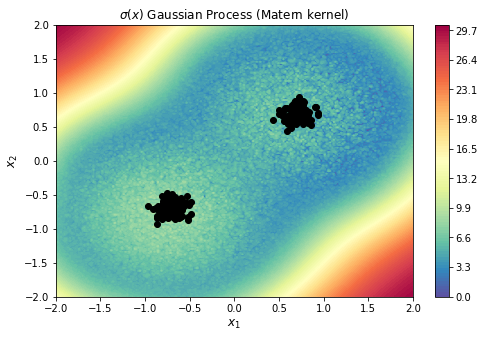

In [46]:
plt.figure(figsize=(8,5))
plt.contourf(xx, yy, zz, 100, cmap='Spectral_r')
plt.colorbar()
plt.scatter(x,y,color='black')
plt.title('$\sigma(x)$ Gaussian Process (Matern kernel)',fontsize=12)
plt.xlabel('$x_1$',fontsize=12)
plt.ylabel('$x_2$',fontsize=12)
plt.show()

In [0]:
def var(x,gamma,x0=0):
  return 1/np.pi/gamma*(gamma**2/((x-x0)**2+gamma**2) )
gamma = 0.3

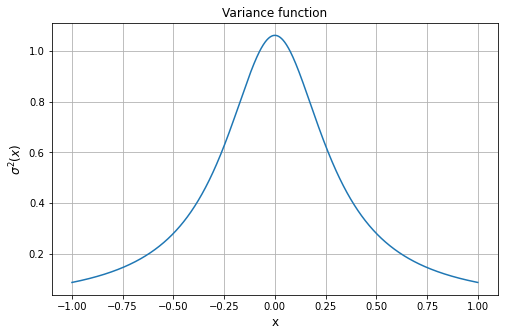

In [7]:
x_np = np.linspace(-1,1,1000)
x = torch.linspace(-1,1,1000)[:,None]

plt.figure(figsize=(8,5))
plt.plot(x,var(x,gamma))
plt.title('Variance function',fontsize=12)
plt.xlabel('x',fontsize=12)
plt.ylabel('$\sigma^2(x)$',fontsize=12)
plt.grid(True)
plt.show()

In [0]:
from random import sample
def avg(x):
  return torch.sin(2*x) + 0.66*torch.cos(7*x) + torch.exp(x**2)

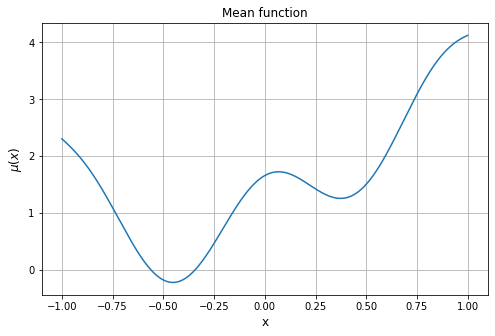

In [9]:
plt.figure(figsize=(8,5))
plt.plot(x,avg(x))
plt.title('Mean function',fontsize=12)
plt.xlabel('x',fontsize=12)
plt.ylabel('$\mu(x)$',fontsize=12)
plt.grid(True)
plt.show()

In [0]:
mu_ =  avg(x)
var_ = var(x,gamma)

In [0]:
N_points = 40

In [0]:
inds = sorted(sample(list(range(1000)),N_points))

In [0]:
points = torch.Tensor(x_np[inds])[:,None]
mu_target = avg(points)
var_target = var(points,gamma)

In [0]:
n_layers=1
p=0.05
VI_reg = Bayesian_ReLU(1, 2, n_layers).to(device)
MCDO_reg = MCDO(1, 1, n_layers).to(device)
opt_vi = optim.Adam(VI_reg.parameters(), lr=1e-3)
opt_mcdo = optim.Adam(MCDO_reg.parameters(), lr=1e-3)

In [0]:
ls_vi = []
ls_mcdo = []
for epoch in range(3000):
  opt_vi.zero_grad()
  opt_mcdo.zero_grad()
  vi_loss = loss_vi(VI_reg,points,mu_target,var_target)
  mcdo_loss = loss_mcdo(MCDO_reg,points,mu_target,var_target)
  vi_loss.backward()
  mcdo_loss.backward()
  ls_vi.append(vi_loss.item())
  ls_mcdo.append(mcdo_loss.item())
  opt_vi.step()
  opt_mcdo.step()



In [0]:
n_samples = 1000

In [0]:
preds_mcdo = torch.cat([MCDO_reg(x) for i in range(n_samples)],dim=1)

In [0]:
mu_mcdo = preds_mcdo.mean(dim=1)
var_mcdo = preds_mcdo.var(dim=1)

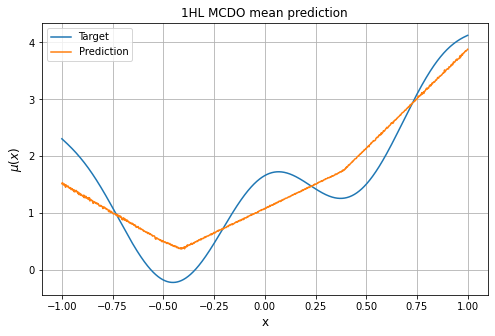

In [60]:
plt.figure(figsize=(8,5))
plt.plot(x,avg(x),label = 'Target')
plt.plot(x,mu_mcdo.detach().numpy(),label = 'Prediction')
plt.title('1HL MCDO mean prediction')
plt.xlabel('x',fontsize=12)
plt.ylabel('$\mu(x)$',fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

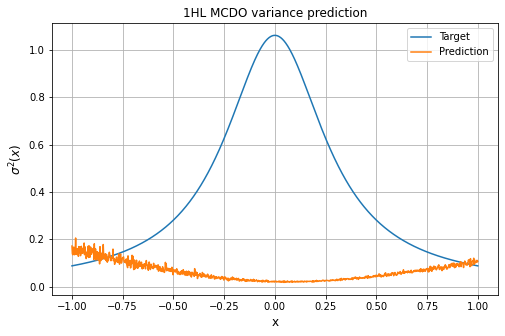

In [61]:
plt.figure(figsize=(8,5))
plt.plot(x,var(x,gamma),label = 'Target')
plt.plot(x,var_mcdo.detach().numpy(),label = 'Prediction')
plt.title('1HL MCDO variance prediction')
plt.xlabel('x',fontsize=12)
plt.ylabel('$\sigma^2(x)$',fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [0]:
n_samples = 128

In [0]:
preds_vi = torch.cat([VI_reg(x) for i in range(n_samples)])

In [0]:
mu_vi = preds_vi[:,0]
mask = (preds_vi[:,1]<=60).int()
var_vi = torch.pow(torch.log(1+EPS+torch.exp(preds_vi[:,1]*mask))+preds_vi[:,1]*(1-mask),2)

In [0]:
bs = x.shape[0]
mu_vi=mu_vi.view(n_samples,bs).T.mean(dim=1)
var_vi=var_vi.view(n_samples,bs).T.mean(dim=1)

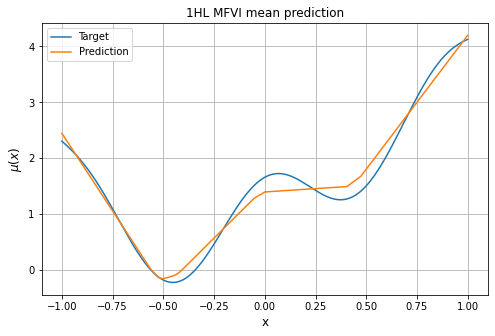

In [66]:
plt.figure(figsize=(8,5))
plt.plot(x,avg(x),label = 'Target')
plt.plot(x,mu_vi.detach().numpy(),label = 'Prediction')
plt.title('1HL MFVI mean prediction')
plt.xlabel('x',fontsize=12)
plt.ylabel('$\mu(x)$',fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

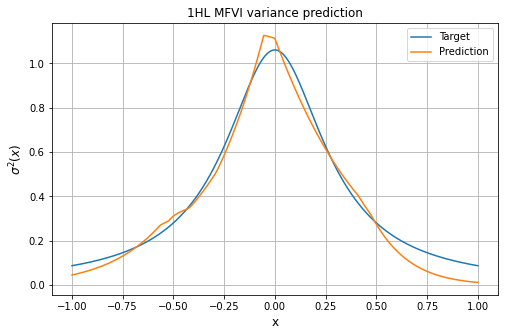

In [67]:
plt.figure(figsize=(8,5))
plt.plot(x,var(x,gamma),label = 'Target')
plt.plot(x,var_vi.detach().numpy(),label = 'Prediction')
plt.title('1HL MFVI variance prediction')
plt.xlabel('x',fontsize=12)
plt.ylabel('$\sigma^2(x)$',fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [0]:
n_layers=2
p=0.05
VI_reg = Bayesian_ReLU(1, 2, n_layers).to(device)
MCDO_reg = MCDO(1, 1, n_layers).to(device)
opt_vi = optim.Adam(VI_reg.parameters(), lr=1e-3)
opt_mcdo = optim.Adam(MCDO_reg.parameters(), lr=1e-3)

In [0]:
ls_vi = []
ls_mcdo = []
for epoch in range(3000):
  opt_vi.zero_grad()
  opt_mcdo.zero_grad()
  vi_loss = loss_vi(VI_reg,points,mu_target,var_target)
  mcdo_loss = loss_mcdo(MCDO_reg,points,mu_target,var_target)
  vi_loss.backward()
  mcdo_loss.backward()
  ls_vi.append(vi_loss.item())
  ls_mcdo.append(mcdo_loss.item())
  opt_vi.step()
  opt_mcdo.step()



In [0]:
n_samples = 1000

In [0]:
preds_mcdo = torch.cat([MCDO_reg(x) for i in range(n_samples)],dim=1)

In [0]:
mu_mcdo = preds_mcdo.mean(dim=1)
var_mcdo = preds_mcdo.var(dim=1)

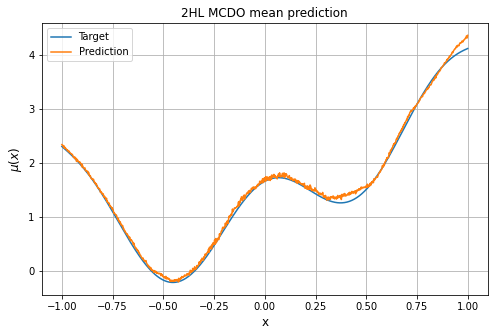

In [19]:
plt.figure(figsize=(8,5))
plt.plot(x,avg(x),label = 'Target')
plt.plot(x,mu_mcdo.detach().numpy(),label = 'Prediction')
plt.title('2HL MCDO mean prediction')
plt.xlabel('x',fontsize=12)
plt.ylabel('$\mu(x)$',fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

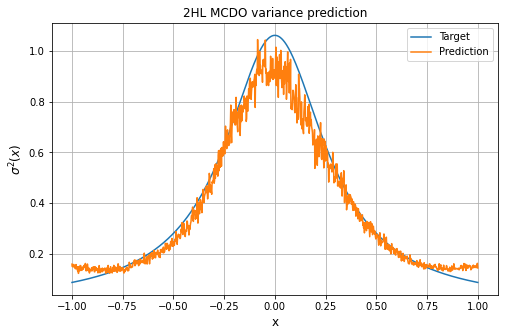

In [20]:
plt.figure(figsize=(8,5))
plt.plot(x,var(x,gamma),label = 'Target')
plt.plot(x,var_mcdo.detach().numpy(),label = 'Prediction')
plt.title('2HL MCDO variance prediction')
plt.xlabel('x',fontsize=12)
plt.ylabel('$\sigma^2(x)$',fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [0]:
n_samples = 128

In [0]:
preds_vi = torch.cat([VI_reg(x) for i in range(n_samples)])

In [0]:
mu_vi = preds_vi[:,0]
mask = (preds_vi[:,1]<=60).int()
var_vi = torch.pow(torch.log(1+EPS+torch.exp(preds_vi[:,1]*mask))+preds_vi[:,1]*(1-mask),2)

In [0]:
bs = x.shape[0]
mu_vi=mu_vi.view(n_samples,bs).T.mean(dim=1)
var_vi=var_vi.view(n_samples,bs).T.mean(dim=1)

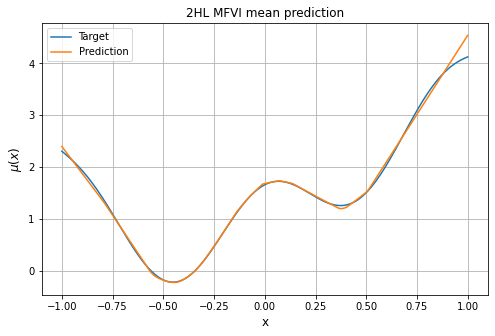

In [25]:
plt.figure(figsize=(8,5))
plt.plot(x,avg(x),label = 'Target')
plt.plot(x,mu_vi.detach().numpy(),label = 'Prediction')
plt.title('2HL MFVI mean prediction')
plt.xlabel('x',fontsize=12)
plt.ylabel('$\mu(x)$',fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

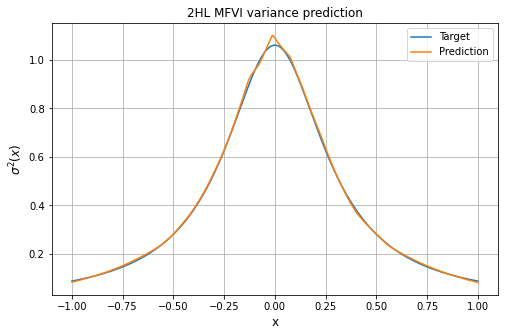

In [26]:
plt.figure(figsize=(8,5))
plt.plot(x,var(x,gamma),label = 'Target')
plt.plot(x,var_vi.detach().numpy(),label = 'Prediction')
plt.title('2HL MFVI variance prediction')
plt.xlabel('x',fontsize=12)
plt.ylabel('$\sigma^2(x)$',fontsize=12)
plt.legend()
plt.grid(True)
plt.show()